# Initial setup

In [1]:
# TensorFlow version
import tensorflow as tf
print(tf.__version__)

2.9.3


In [2]:
# Which GPU?
!nvidia-smi

Tue Dec 13 05:52:20 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.47.03    Driver Version: 510.47.03    CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   60C    P0    27W /  70W |      0MiB / 15360MiB |     10%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [5]:
!pip install opencv-python

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.9/60.9 MB 21.8 MB/s eta 0:00:0000:0100:01


In [6]:
# Other imports
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import *
from tensorflow.keras.models import *

import tensorflow_datasets as tfds
tfds.disable_progress_bar()

import matplotlib.pyplot as plt
import numpy as np
import random
import shutil
import time
import cv2
import os

# Fix the seeds
SEED = 666
tf.random.set_seed(SEED)
np.random.seed(SEED)

## Data collection

In [7]:
# Gather Flowers dataset
train_ds, validation_ds = tfds.load(
    "tf_flowers",
    split=["train[:85%]", "train[85%:]"],
    as_supervised=True
)

# Specify the class labels, we would need this to create targeted attacks
CLASSES = ["daisy", "dandelion", "roses", "sunflowers", "tulips"]

Dataset tf_flowers downloaded and prepared to /home/jupyter/tensorflow_datasets/tf_flowers/3.0.1. Subsequent calls will reuse this data.


2022-12-13 05:53:44.397748: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-13 05:53:44.484863: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-13 05:53:44.486676: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-13 05:53:44.491336: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

2022-12-13 05:54:23.989793: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


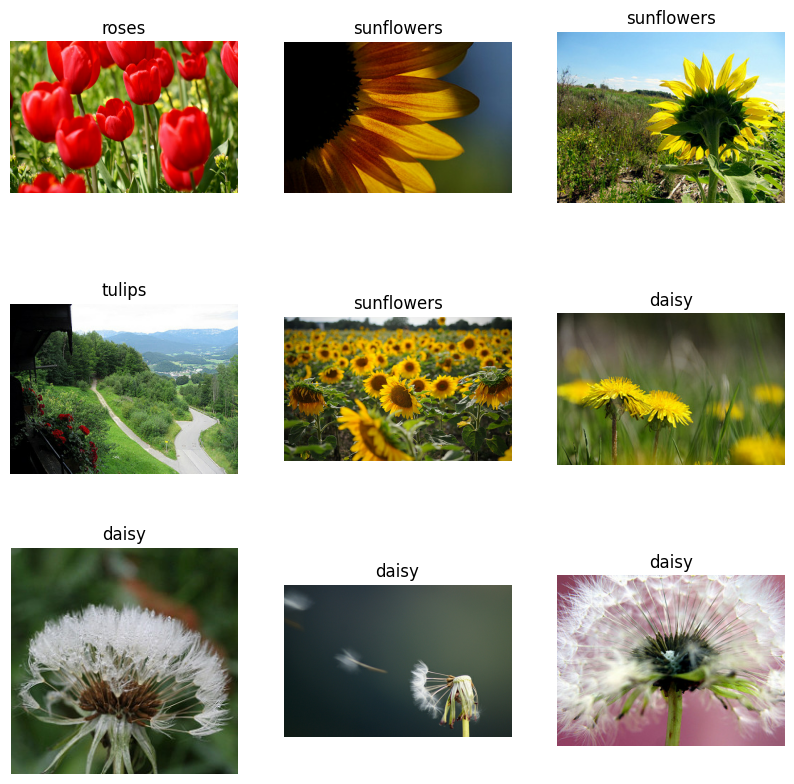

In [8]:
# Visualization
plt.figure(figsize=(10, 10))
for i, (image, label) in enumerate(train_ds.take(9)):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image)
    plt.title(CLASSES[int(label)])
    plt.axis("off")

## Data preparation

In [9]:
# Image preprocessing utils

SIZE = (224, 224)

def preprocess_image(image, label):
    # image = tf.image.convert_image_dtype(image, tf.float32)
    # The model includes the normalization steps
    image = tf.image.resize(image, SIZE)
    return (image, label)

In [10]:
# Construct TensorFlow dataset
BATCH_SIZE = 64
AUTO = tf.data.experimental.AUTOTUNE

train_ds = (
    train_ds
    .map(preprocess_image, num_parallel_calls=AUTO)
    .cache()
    .shuffle(1024)
    .batch(BATCH_SIZE)
    .prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
)

validation_ds = (
    validation_ds
    .map(preprocess_image, num_parallel_calls=AUTO)
    .cache()
    .batch(BATCH_SIZE)
    .prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
)

## Model utilities

In [11]:
# Reference: https://keras.io/examples/vision/image_classification_efficientnet_fine_tuning/
def get_training_model(base_model):
    inputs = Input(shape=(224, 224, 3))
    x = base_model(inputs, training=False)
    x = GlobalAveragePooling2D()(x)
    x = BatchNormalization()(x)

    top_dropout_rate = 0.2
    x = Dropout(top_dropout_rate)(x)
    x = Dense(5, activation="softmax")(x)
    classifier = Model(inputs=inputs, outputs=x)
    
    return classifier

def plot_progress(hist):
    plt.plot(hist.history["loss"], label="train_loss")
    plt.plot(hist.history["val_loss"], label="validation_loss")
    plt.plot(hist.history["accuracy"], label="training_accuracy")
    plt.plot(hist.history["val_accuracy"], label="validation_accuracy")
    plt.title("Training Progress")
    plt.ylabel("accuracy/loss")
    plt.xlabel("epoch")
    plt.legend(loc="upper left")
    plt.show()

Fetch the [AdvProp](https://arxiv.org/abs/1911.09665) training checkpoints for EfficientNetB0 and convert the checkpoints to `.h5`. 

In [12]:
!wget -q https://storage.googleapis.com/cloud-tpu-checkpoints/efficientnet/advprop/efficientnet-b0.tar.gz
!tar -xf efficientnet-b0.tar.gz

In [13]:
!wget -q https://raw.githubusercontent.com/yixingfu/tensorflow/updateweights/tensorflow/python/keras/applications/efficientnet_weight_update_util.py
!python efficientnet_weight_update_util.py --model b0 --notop --ckpt \
       efficientnet-b0/model.ckpt --o efficientnetb0_notop.h5

2022-12-13 06:00:58.879322: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-13 06:00:58.890018: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-13 06:00:58.891787: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-13 06:00:58.893677: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

## Training an EfficientNetB0 initialized with noisy student training weights

In [14]:
# Load the EfficientNetB0 model but exclude the classification layers
# Note that the model was trained using AdvProp (https://arxiv.org/abs/1911.09665)
base_model_eb0_ap = EfficientNetB0(weights="efficientnetb0_notop.h5", include_top=False)
base_model_eb0_ap.trainable = False # We are not fine-tuning at this point
get_training_model(base_model_eb0_ap).summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 batch_normalization (BatchN  (None, 1280)             5120      
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 5)                 6405  

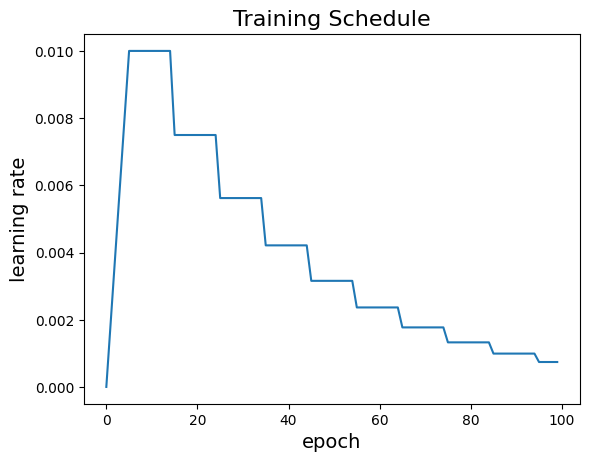

In [15]:
# CUSTOM LEARNING SCHEUDLE
# Reference: https://www.kaggle.com/cdeotte/how-to-compete-with-gpus-workshop
LR_START = 1e-5
LR_MAX = 1e-2
LR_RAMPUP_EPOCHS = 5
LR_SUSTAIN_EPOCHS = 0
LR_STEP_DECAY = 0.75

def lrfn(epoch):
    if epoch < LR_RAMPUP_EPOCHS:
        lr = (LR_MAX - LR_START) / LR_RAMPUP_EPOCHS * epoch + LR_START
    elif epoch < LR_RAMPUP_EPOCHS + LR_SUSTAIN_EPOCHS:
        lr = LR_MAX
    else:
        lr = LR_MAX * LR_STEP_DECAY**((epoch - LR_RAMPUP_EPOCHS - LR_SUSTAIN_EPOCHS)//10)
    return lr
    
lr2 = tf.keras.callbacks.LearningRateScheduler(lrfn, verbose=True)

rng = [i for i in range(100)]
y = [lrfn(x) for x in rng]
plt.plot(rng, y); 
plt.xlabel('epoch',size=14); plt.ylabel('learning rate',size=14)
plt.title('Training Schedule',size=16); plt.show()

In [16]:
# Early stopping callback
es = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss", patience=5, restore_best_weights=True
)


Epoch 1: LearningRateScheduler setting learning rate to 1e-05.
Epoch 1/30


2022-12-13 06:03:43.307494: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8200


49/49 [==============================] - 22s 190ms/step - loss: 2.3197 - accuracy: 0.2304 - val_loss: 1.7268 - val_accuracy: 0.2327 - lr: 1.0000e-05

Epoch 2: LearningRateScheduler setting learning rate to 0.0020080000000000002.
Epoch 2/30
49/49 [==============================] - 7s 138ms/step - loss: 0.7062 - accuracy: 0.7612 - val_loss: 0.3920 - val_accuracy: 0.8818 - lr: 0.0020

Epoch 3: LearningRateScheduler setting learning rate to 0.004006.
Epoch 3/30
49/49 [==============================] - 7s 136ms/step - loss: 0.2930 - accuracy: 0.8962 - val_loss: 0.3134 - val_accuracy: 0.8927 - lr: 0.0040

Epoch 4: LearningRateScheduler setting learning rate to 0.006004000000000001.
Epoch 4/30
49/49 [==============================] - 7s 136ms/step - loss: 0.1937 - accuracy: 0.9311 - val_loss: 0.2585 - val_accuracy: 0.9055 - lr: 0.0060

Epoch 5: LearningRateScheduler setting learning rate to 0.008002.
Epoch 5/30
49/49 [==============================] - 7s 135ms/step - loss: 0.1643 - accuracy: 

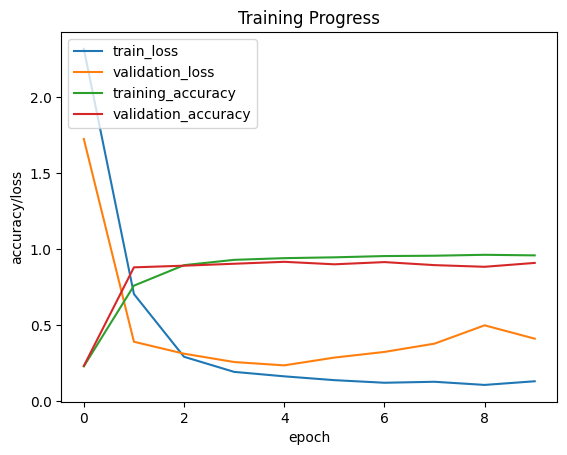

In [17]:
# Train the model
model_eb0_ap = get_training_model(base_model_eb0_ap)
model_eb0_ap.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
start = time.time()
h = model_eb0_ap.fit(train_ds,
              validation_data=validation_ds,
              epochs=30,
              callbacks=[lr2, es])
print("Total training time (seconds): ",time.time()-start)
plot_progress(h)

## Training an EfficientNetB0 initialized with ImageNet weights

In [18]:
# Load the EfficientNetB0 model but exclude the classification layers
# This time the weights are from traditional ImageNet pre-training
base_model_eb0 = EfficientNetB0(weights="imagenet", include_top=False)
base_model_eb0.trainable = False # We are not fine-tuning at this point


Epoch 1: LearningRateScheduler setting learning rate to 1e-05.
Epoch 1/30
49/49 [==============================] - 13s 162ms/step - loss: 2.2689 - accuracy: 0.2567 - val_loss: 1.7004 - val_accuracy: 0.2709 - lr: 1.0000e-05

Epoch 2: LearningRateScheduler setting learning rate to 0.0020080000000000002.
Epoch 2/30
49/49 [==============================] - 7s 136ms/step - loss: 0.6676 - accuracy: 0.7715 - val_loss: 0.3753 - val_accuracy: 0.8745 - lr: 0.0020

Epoch 3: LearningRateScheduler setting learning rate to 0.004006.
Epoch 3/30
49/49 [==============================] - 7s 135ms/step - loss: 0.2909 - accuracy: 0.9003 - val_loss: 0.2716 - val_accuracy: 0.9145 - lr: 0.0040

Epoch 4: LearningRateScheduler setting learning rate to 0.006004000000000001.
Epoch 4/30
49/49 [==============================] - 7s 137ms/step - loss: 0.1823 - accuracy: 0.9346 - val_loss: 0.2231 - val_accuracy: 0.9164 - lr: 0.0060

Epoch 5: LearningRateScheduler setting learning rate to 0.008002.
Epoch 5/30
49/49 [

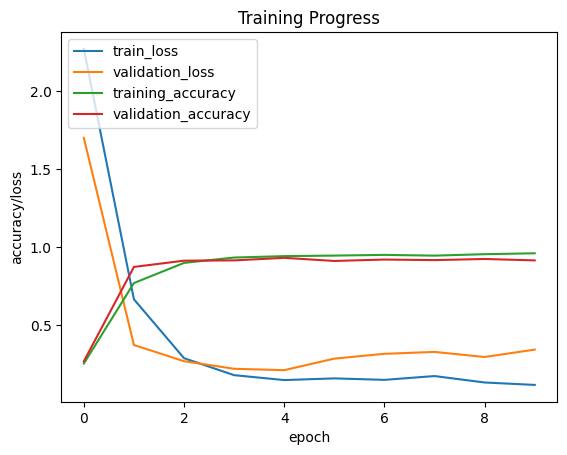

In [19]:
# Train the model
model_eb0 = get_training_model(base_model_eb0)
model_eb0.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
start = time.time()
h = model_eb0.fit(train_ds,
              validation_data=validation_ds,
              epochs=30,
              callbacks=[lr2, es])
print("Total training time (seconds): ",time.time()-start)
plot_progress(h)

## Plotting sample predictions

In [20]:
# Utility to plot sample predictions 
def plot_predictions(images, labels, probability):
    plt.figure(figsize=(15, 15))
    for i, image in enumerate(images):
        ax = plt.subplot(4, 4, i + 1)
        plt.imshow(image.numpy().astype("uint8"))
        predicted_label = CLASSES[np.argmax(probability[i])]
        maximum_probability = "{:.3f}".format(max(probability[i]))
        text = "{} with probability: {}".format(predicted_label, maximum_probability) + \
            "\nGround-truth: {}".format(CLASSES[int(labels[i])])
        plt.title(text)
        plt.axis("off")
    plt.show()

### Inference with the regular EfficienNet model

2/2 [==============================] - 2s 21ms/step


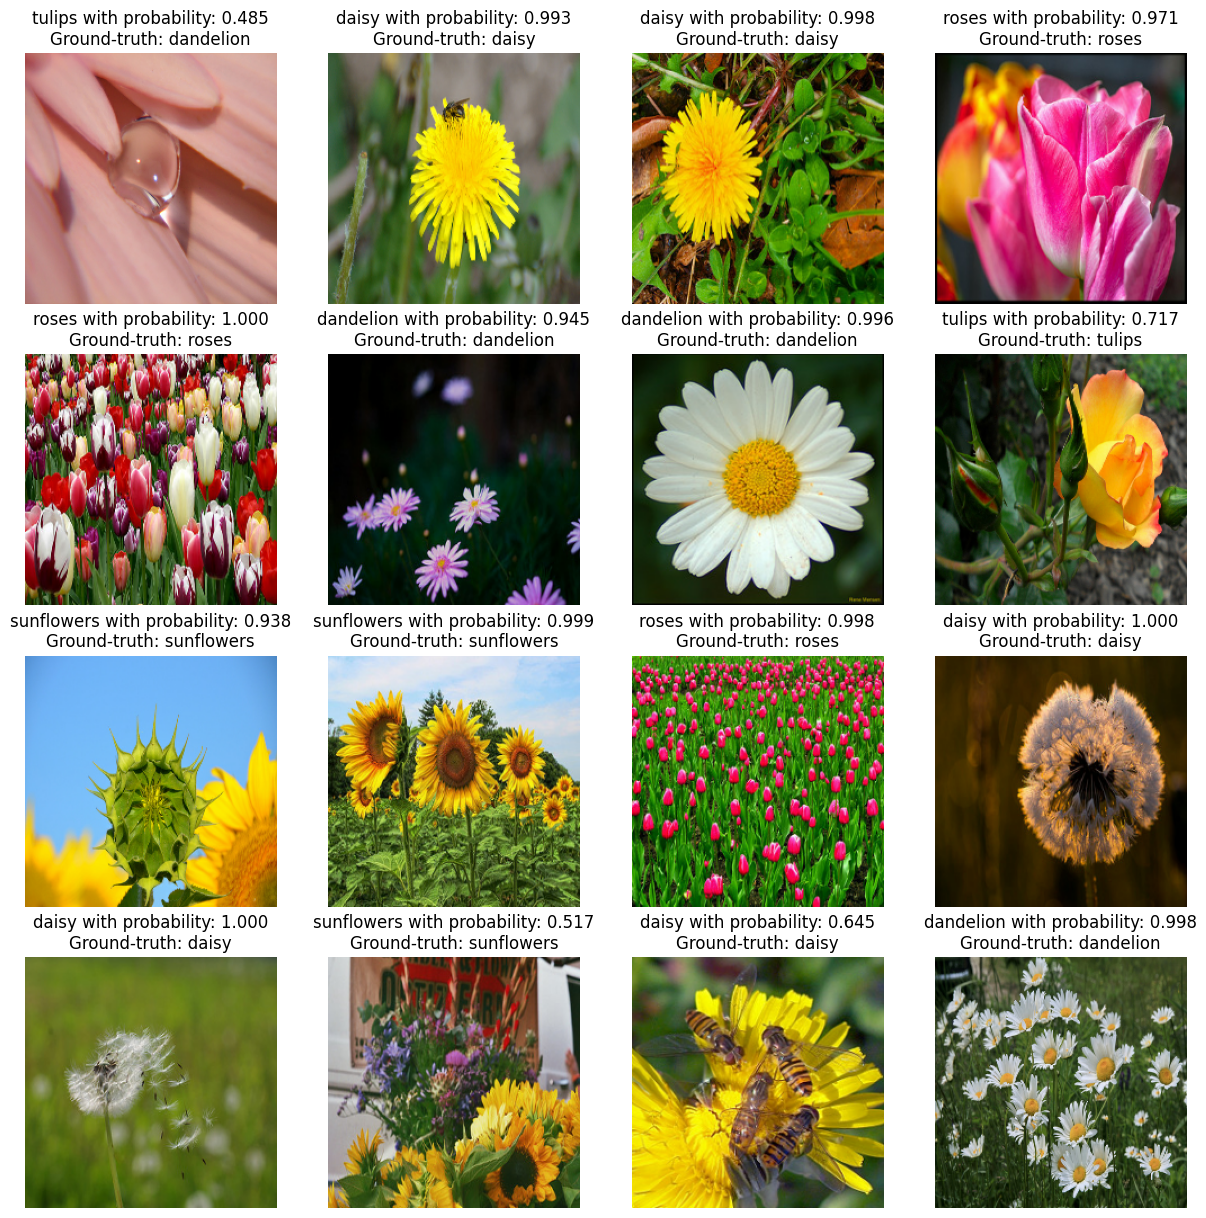

In [21]:
# Let's run inference on a batch of images from the validation set
(batch_images, batch_labels) = next(iter(validation_ds))
predictions = model_eb0.predict(batch_images)
plot_predictions(batch_images[:16], batch_labels[:16], predictions[:16])

### Inference with the AdvProp weights initialized EfficientNet model

2/2 [==============================] - 1s 72ms/step


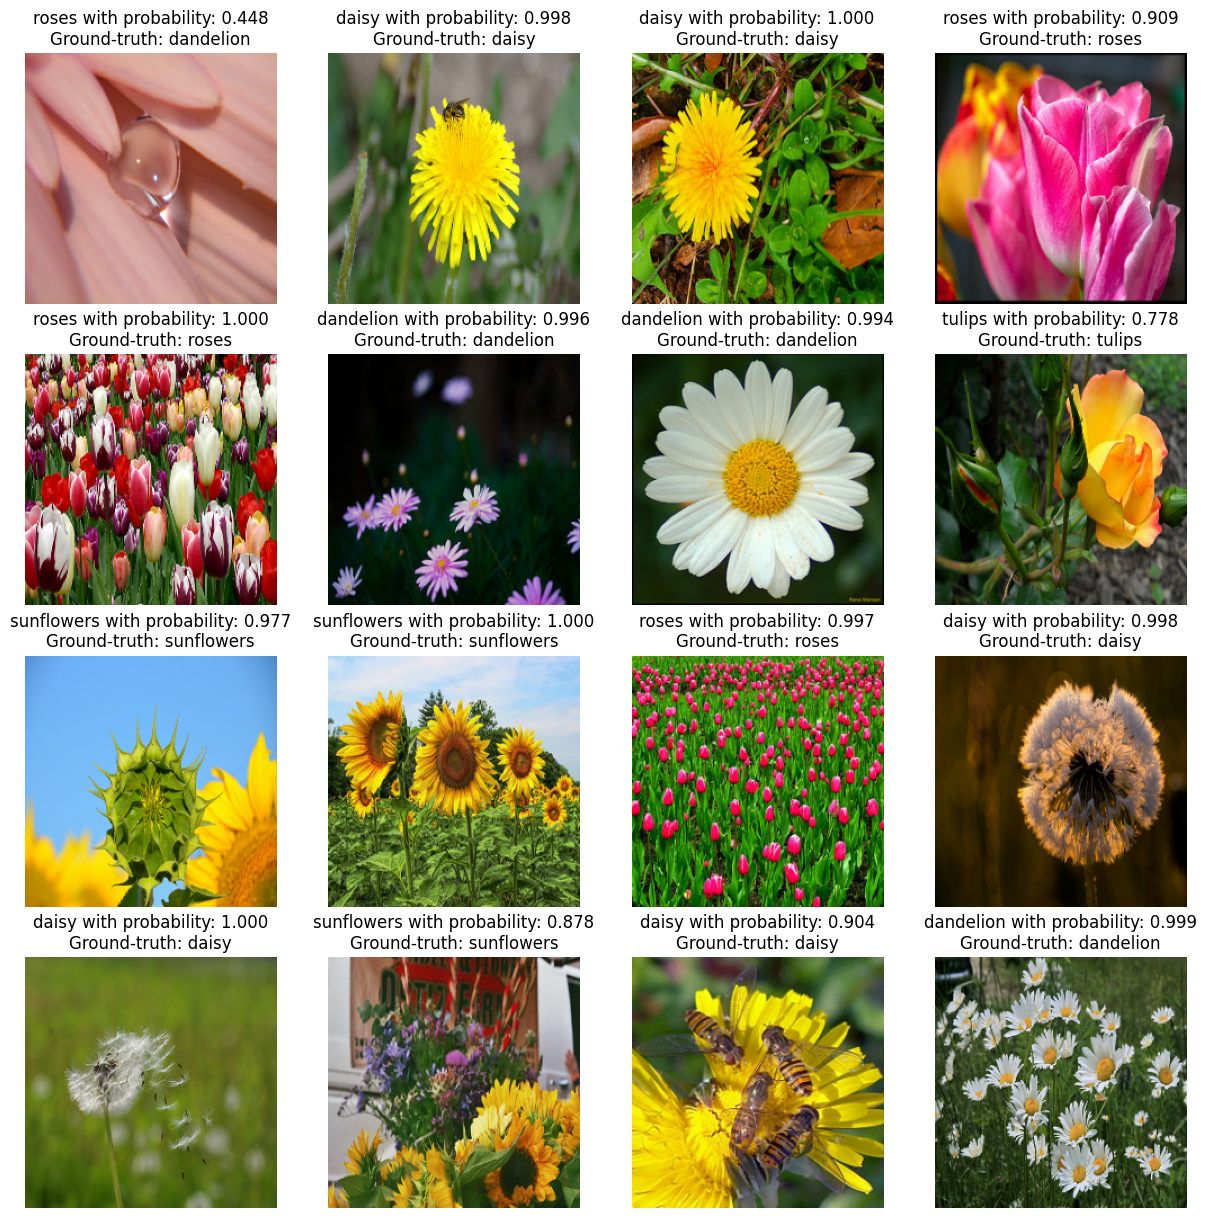

In [22]:
# Let's run inference on a batch of images from the validation set
(batch_images, batch_labels) = next(iter(validation_ds))
predictions = model_eb0_ap.predict(batch_images)
plot_predictions(batch_images[:16], batch_labels[:16], predictions[:16])

## Utilities for creating a targeted adversarial example

In [23]:
#@title
EPS = 2./255

def clip_eps(delta_tensor):
    return tf.clip_by_value(delta_tensor, clip_value_min=-EPS, clip_value_max=EPS)

In [24]:
#@title
def generate_adversaries_targeted(model, image_tensor, delta, 
    true_index, target_index):
    # Loss and optimizer
    scc_loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
    optimizer = tf.keras.optimizers.Adam(learning_rate=5e-3)

    for t in range(350):
        plt.show()
        with tf.GradientTape() as tape:
            tape.watch(delta)
            inp = (image_tensor + delta)
            predictions = model(inp, training=False)
            loss = (- scc_loss(tf.convert_to_tensor([true_index]), predictions) + 
	                    scc_loss(tf.convert_to_tensor([target_index]), predictions))
            if t % 20 == 0:
                print(t, loss.numpy())
                # plt.imshow(50*delta.numpy().squeeze()+0.5)
            
        # Get the gradients
        gradients = tape.gradient(loss, delta)
        
        # Update the weights
        optimizer.apply_gradients([(gradients, delta)])

        delta.assign_add(clip_eps(delta))

    return delta

In [25]:
#@title
def perturb_image(model, image, true, target):
    print("Before adversarial attack")
    # preprocessed_image = image/255.
    probabilities = model.predict(image)
    class_index = np.argmax(probabilities)
    print("Ground-truth label: {} predicted label: {}".format(CLASSES[true], CLASSES[class_index]))
    
    # Initialize the perturbation quantity
    image_tensor = tf.constant(image, dtype=tf.float32)
    delta = tf.Variable(tf.zeros_like(image_tensor), trainable=True)

    # Get the adversary vector
    delta_tensor = generate_adversaries_targeted(model, image_tensor, delta, true, target)

    # See if the image changes
    plt.imshow((image_tensor + delta_tensor).numpy().astype("uint8").squeeze())
    plt.show()

    # Generate prediction
    perturbed_image = (image_tensor + delta_tensor)
    print("After adversarial attack")
    
    # Generate predictions
    preds = model.predict(perturbed_image)[0]
    i = np.argmax(preds)
    pred_label = CLASSES[i]

    print("Predicted label: {}".format(pred_label))
    cv2.imwrite("perturbed_image.png", perturbed_image.numpy().squeeze())

Turning a dandelion (last image from the figure above) to a tulip. 

In [26]:
# Pick an image from the validation set
index = 15
sample_val_image = (batch_images[index])
sample_val_image = np.expand_dims(sample_val_image, 0)

Before adversarial attack
1/1 [==============================] - 2s 2s/step
Ground-truth label: dandelion predicted label: dandelion
0 10.740772


/opt/conda/lib/python3.7/site-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


20 8.919712
40 7.3137913
60 5.9185953
80 4.687688
100 3.5646272
120 2.4981022
140 1.4522634
160 0.39576286
180 -0.7046065
200 -1.8652449
220 -3.1065145
240 -4.454239
260 -5.9398785
280 -7.584302
300 -9.401696
320 -11.319687
340 -13.239187


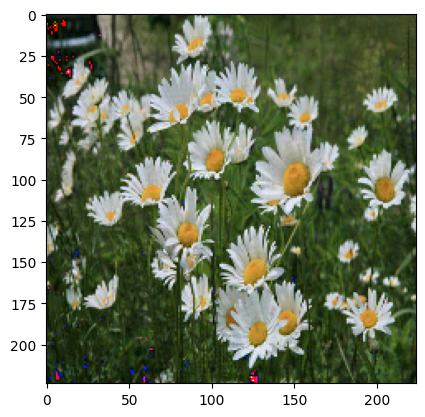

After adversarial attack
1/1 [==============================] - 0s 32ms/step
Predicted label: tulips


In [27]:
#@title EfficientNetB0 with ImageNet initialization
# Tulips class index 4
perturb_image(model_eb0, sample_val_image, batch_labels[index].numpy(), 4)

Before adversarial attack
1/1 [==============================] - 1s 1s/step
Ground-truth label: dandelion predicted label: dandelion
0 9.687346
20 8.621589
40 7.535997
60 6.422162
80 5.262435
100 4.0472097
120 2.7762337
140 1.4798417
160 0.20879221
180 -1.0085644
200 -2.1727557
220 -3.3054318
240 -4.428012
260 -5.5516267
280 -6.679329
300 -7.8121443
320 -8.954315
340 -10.11537


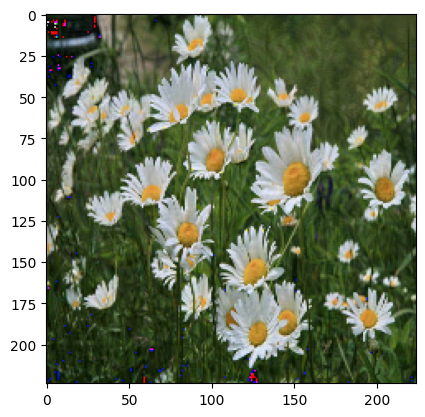

After adversarial attack
1/1 [==============================] - 0s 32ms/step
Predicted label: tulips


In [28]:
#@title EfficientNetB0 with AdvProp initialization
perturb_image(model_eb0_ap, sample_val_image, batch_labels[index].numpy(), 4)